In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
# Loading the wind Data
file_path = 'D:/Fuzzy input data.xlsx'  # Adjust path if needed
winddata = pd.read_excel(file_path)

# Processing the DateTime Column
winddata.columns = winddata.columns.str.strip()
if 'Time' not in winddata.columns:
    raise KeyError("'Time' column not found. Available columns: {}".format(winddata.columns))

winddata['Time'] = pd.to_numeric(winddata['Time'], errors='coerce')
winddata = winddata.dropna(subset=['Time'])
winddata = winddata.sort_values(by='Time')
winddata['Timestamp'] = pd.Timestamp('2015-01-01') + pd.to_timedelta(winddata['Time'], unit='D')


In [10]:
# Extracting features and target
X = winddata[['WS', 'pitch']].values
y = winddata['Power'].values.reshape(-1, 1)

# Train and test data split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_test = scaler_X.transform(X_test_raw)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)

In [12]:
# Converting to tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Defining Constants
# Air density in kg/m^3
RHO = 1.225  
#Wind turbine blade swept area (unit area assumption)
AREA = 1.0   

In [14]:
# Scaling for inverse transforms
mean_ws = tf.constant(scaler_X.mean_[0], dtype=tf.float32)
std_ws = tf.constant(np.sqrt(scaler_X.var_[0]), dtype=tf.float32)
mean_pitch = tf.constant(scaler_X.mean_[1], dtype=tf.float32)
std_pitch = tf.constant(np.sqrt(scaler_X.var_[1]), dtype=tf.float32)

mean_y = tf.constant(scaler_y.mean_[0], dtype=tf.float32)
std_y = tf.constant(np.sqrt(scaler_y.var_[0]), dtype=tf.float32)

In [16]:
# Defining PINN Model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(128, activation='relu')
        self.hidden2 = tf.keras.layers.Dense(128, activation='relu')
        self.hidden3 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        x = self.hidden3(x)
        return self.output_layer(x)


pinn_model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [18]:
# Training with Physics-Informed Loss
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = pinn_model(x_batch, training=True)
        data_loss = tf.reduce_mean(tf.square(y_batch - y_pred))

        # Decoding inputs
        ws_scaled = x_batch[:, 0:1]
        pitch_scaled = x_batch[:, 1:2]

        ws = ws_scaled * std_ws + mean_ws
        pitch = pitch_scaled * std_pitch + mean_pitch

        # Cp is the exponential decay function of pitch
        cp = 0.5 * tf.math.exp(-tf.square(pitch))

        theoretical_power = 0.5 * RHO * AREA * tf.pow(ws, 3) * cp
        theoretical_power = tf.reshape(theoretical_power, (-1, 1))

        
        theoretical_power_scaled = (theoretical_power - mean_y) / std_y

        # Physics-informed loss
        physics_loss = tf.reduce_mean(tf.square(y_pred - theoretical_power_scaled))

        # Total loss
        lambda_phys = 0.1
        total_loss = data_loss + lambda_phys * physics_loss
    gradients = tape.gradient(total_loss, pinn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables))
    return total_loss, data_loss, physics_loss


In [20]:
# Training 
EPOCHS = 200
BATCH_SIZE = 64
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    total_loss_epoch = 0.0
    for i in range(0, len(X_train_tf), BATCH_SIZE):
        x_batch = X_train_tf[i:i + BATCH_SIZE]
        y_batch = y_train_tf[i:i + BATCH_SIZE]
        total_loss, data_loss, physics_loss = train_step(x_batch, y_batch)
        total_loss_epoch += total_loss

    # Validation loss
    y_val_pred = pinn_model(X_test_tf, training=False)
    val_loss = tf.reduce_mean(tf.square(y_test_tf - y_val_pred))

    train_losses.append(total_loss_epoch.numpy() / (len(X_train_tf) / BATCH_SIZE))
    val_losses.append(val_loss.numpy())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss_epoch.numpy():.4f}, Validation Loss = {val_loss.numpy():.4f}")


Epoch 0: Total Loss = 223.0824, Validation Loss = 0.0803
Epoch 10: Total Loss = 216.4356, Validation Loss = 0.0807
Epoch 20: Total Loss = 216.4126, Validation Loss = 0.0822
Epoch 30: Total Loss = 216.3962, Validation Loss = 0.0819
Epoch 40: Total Loss = 216.3876, Validation Loss = 0.0828
Epoch 50: Total Loss = 216.3815, Validation Loss = 0.0834
Epoch 60: Total Loss = 216.3804, Validation Loss = 0.0834
Epoch 70: Total Loss = 216.3797, Validation Loss = 0.0826
Epoch 80: Total Loss = 216.3772, Validation Loss = 0.0818
Epoch 90: Total Loss = 216.3742, Validation Loss = 0.0815
Epoch 100: Total Loss = 216.3727, Validation Loss = 0.0814
Epoch 110: Total Loss = 216.3703, Validation Loss = 0.0811
Epoch 120: Total Loss = 216.3689, Validation Loss = 0.0811
Epoch 130: Total Loss = 216.3673, Validation Loss = 0.0812
Epoch 140: Total Loss = 216.3661, Validation Loss = 0.0811
Epoch 150: Total Loss = 216.3651, Validation Loss = 0.0810
Epoch 160: Total Loss = 216.3645, Validation Loss = 0.0810
Epoch 17

In [26]:

predictions_scaled = pinn_model(X_test_tf)
predictions = scaler_y.inverse_transform(predictions_scaled.numpy())
actual = scaler_y.inverse_transform(y_test_tf.numpy())


time_test = winddata['Timestamp'].values[-len(actual):]

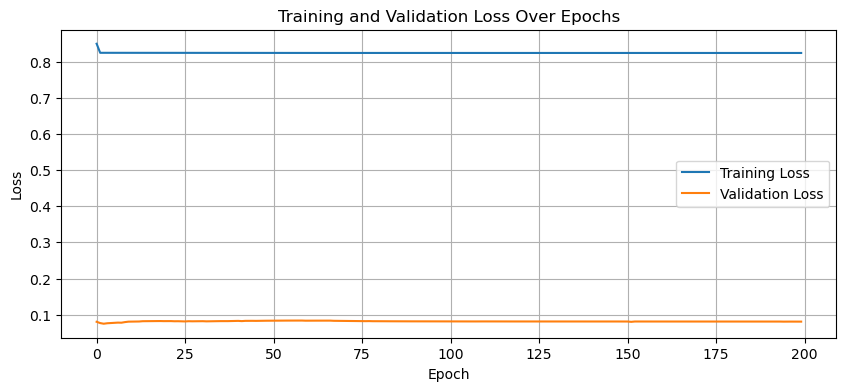

In [28]:
# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Error Metrics
mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)
rmse = math.sqrt(mse)

print(f"\nEvaluation on Test Set:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error):  {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")


Evaluation on Test Set:
MAE  (Mean Absolute Error): 23.9804
MSE  (Mean Squared Error):  637.2988
RMSE (Root Mean Squared Error): 25.2448


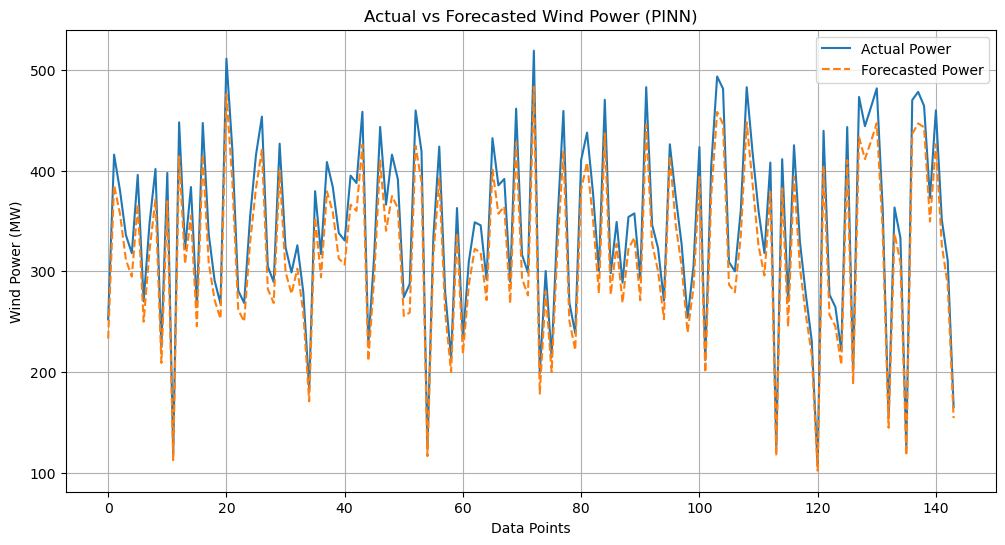

In [32]:
# Plotting the forecasted values against the actual wind power values
plt.figure(figsize=(12, 6))
plt.plot(range(144), actual[-144:], label='Actual Power')
plt.plot(range(144), predictions[-144:], label='Forecasted Power', linestyle='--')
plt.xlabel('Data Points')
plt.ylabel('Wind Power (MW)')
plt.title('Actual vs Forecasted Wind Power (PINN)')
plt.legend()
plt.grid(True)
plt.show()